# Imports

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# URL, HTML, brackets, digits
import re
from bs4 import BeautifulSoup
# Contractions
!pip install contractions
import contractions

# NLTK
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Tokenization, punctuations and stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.corpus import stopwords, wordnet

# Lemmatization
from nltk.stem import WordNetLemmatizer

# Sentiment Analysis
from textblob import TextBlob

# Frequency Analysis
from nltk.probability import FreqDist
from wordcloud import WordCloud

# CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Training
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Models
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
# import xgboost as xgb

from sklearn.metrics import f1_score

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to /home/chinmay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/chinmay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/chinmay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/chinmay/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
df = pd.read_csv("../datasets/train_df.csv")
test_df = pd.read_csv("../datasets/test_df.csv")

In [7]:
df.head()

,qid,question_text,target
0,dda0b0efc8ba86e81ec4,What are interesting facts about Microsoft his...,0
1,dc708b74a108d0fc0ad9,What are those things which are not gonna happ...,0
2,06a27ec5d82dacd8bfe0,"What should I know to avoid being ""upsold"" whe...",0
3,00cbb6b17e3ceb7c5358,How I add any account with payment bank?,0
4,7c304888973a701585a0,Which Multi level marketing products are actua...,0


In [8]:
df.shape

(1000000, 3)

# Pre-processing

## Missing values and duplicate entries

In [9]:
df.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

In [10]:
(df=='?').sum()

qid              0
question_text    0
target           0
dtype: int64

In [11]:
(df==' ').sum()

qid              0
question_text    0
target           0
dtype: int64

There are no missing values.

In [12]:
df.duplicated().sum()

0

There are no duplicate entries.

## Examining target

In [13]:
df[df['target']==1]['target'].value_counts()

1    61870
Name: target, dtype: int64

In [14]:
df['target'].value_counts()

0    938130
1     61870
Name: target, dtype: int64

Text(0.5, 1.0, 'Target value count')

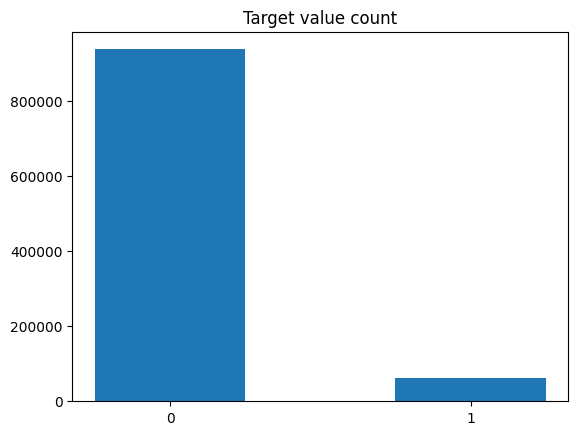

In [15]:
plt.bar(['0','1'], df['target'].value_counts(), width=0.5)
plt.title('Target value count')

# Text pre-processing

We first split the sentence into a list and expand all contractions. Then we combine it back to a sentence. 
Then we again tokenize it.

### Removing URL, HTML, brackets, digits

In [16]:
def remove_url(data_column):
  return data_column.apply(lambda sentence: re.sub(r'https://','', sentence))
def remove_html(data_column):
  return data_column.apply(lambda sentence: BeautifulSoup(sentence, 'html.parser').get_text())
def remove_bracket(data_column):
  temp = data_column.apply(lambda sentence: re.sub('\(.*?\)','', sentence))
  return temp.apply(lambda sentence: re.sub('\[.*?\]','', sentence))
def remove_digit(data_column):
  return data_column.apply(lambda sentence: re.sub('[0-9]','', sentence))
def remove_underscore(data_column):
  return data_column.apply(lambda sentence: sentence.replace("_",""))

### Expanding contractions



In [17]:
def expand_contractions(data_column):
  contractions_expanded = data_column.apply(lambda sentence: [contractions.fix(word) for word in sentence.split()])
  return [' '.join(map(str, word)) for word in contractions_expanded]

### Tokenization, converting to lower case, removing punctuations and stopwords

Since stopwords like "a, he, she, you, in, etc." do not add any significant meaning to the processing, we remove them from the lower case tokenized sentences.

In [18]:
def tokenize(data_column):
  return data_column.apply(word_tokenize)
def lower_case(data_column):
  return data_column.apply(lambda tokens: [word.lower() for word in tokens])
def remove_punctuation(data_column):
  return data_column.apply(lambda tokens: [re.sub(r'[^\w\s]', '', word) for word in tokens])
  # punctuations = string.punctuation
  # return data_column.apply(lambda tokens: [word for word in tokens if word not in punctuations])
def remove_stopwords(data_column):
  stop_words = set(stopwords.words('english'))
  return data_column.apply(lambda tokens: [word for word in tokens if word not in stop_words and word])

### Lemmatization

Getting the base form of each word. We chose lemmatization over
stemming because stemming doesn’t give accurate results. Eg: for the word “scaling”,
lemmatization gives “scale” while stemming gives “scal”.

NLTK's word lemmatizer requires part of speech (POS) tag of a word, to lemmatize it.

In [19]:
def pos_tags(data_column):
  return data_column.apply(nltk.tag.pos_tag)

Word lemmatizer requires the POS tags to be in wordnet format.

In [20]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [21]:
def to_wordnet(data_column):
  return data_column.apply(lambda words: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in words])
def word_lemmatizer(data_column):
  wnl = WordNetLemmatizer()
  return data_column.apply(lambda words: [wnl.lemmatize(word, tag) for word, tag in words])

# Pre-processing function calls

In [22]:
def pre_processing(data, df):
  # data = remove_url(data)
  # data = remove_html(data)
  # data = remove_bracket(data)
  # data = remove_digit(data)
  # data = remove_underscore(data)

  # df['sentences'] = expand_contractions(data)
  data = tokenize(df['text'])
  df.drop('sentences', axis='columns', inplace=True)
  # data = lower_case(data)
  # data = remove_punctuation(data)
  # data = remove_stopwords(data)

  # data = pos_tags(data)
  # data = to_wordnet(data)
  return data

In [23]:
df.shape, test_df.shape

((1000000, 3), (306122, 2))

In [24]:
full_df = pd.concat([df, test_df])

In [25]:
full_df.shape

(1306122, 3)

In [26]:
full_df['processed_data'] = pre_processing(full_df['question_text'], full_df)

In [27]:
full_df.head()

,qid,question_text,target,processed_data
0,dda0b0efc8ba86e81ec4,What are interesting facts about Microsoft his...,0.0,"[What, are, interesting, facts, about, Microso..."
1,dc708b74a108d0fc0ad9,What are those things which are not gonna happ...,0.0,"[What, are, those, things, which, are, not, go..."
2,06a27ec5d82dacd8bfe0,"What should I know to avoid being ""upsold"" whe...",0.0,"[What, should, I, know, to, avoid, being, ``, ..."
3,00cbb6b17e3ceb7c5358,How I add any account with payment bank?,0.0,"[How, I, add, any, account, with, payment, ban..."
4,7c304888973a701585a0,Which Multi level marketing products are actua...,0.0,"[Which, Multi, level, marketing, products, are..."


# Language Analysis

### Pycld2

In [28]:
# !pip install pycld2

In [29]:
# import pycld2 as cld2

In [30]:
# def func(sentence):
#   try:
#     ans = cld2.detect(sentence, returnVectors=True)[3][0][3]
#   except:
#     print(sentence, len(sentence))
#   else:
#     return ans
# df['language'] = df['expanded_sentence'].apply(lambda sentence: func(sentence))
# # df['language'] = df['expanded_sentence'].apply(lambda sentence: cld2.detect(sentence, returnVectors=True)[3][0][3])

In [31]:
# df['language'].value_counts()

In [32]:
# pd.options.display.max_colwidth = 150
# x = df[df['language']!='en']
# x[x['language']=='un'][['question_text','language']]

Pycld2 was giving a lot of unknown 'un' predictions.

### Langid

In [33]:
# !pip install langid

In [34]:
# import langid
# # langid.classify(text2)
# df['language_langid'] = df['expanded_sentence'].apply(lambda sentence: langid.classify(sentence))
# df['language_langid'].value_counts()
# # x = df[df['language']!='en']
# # x[x['language']=='un'][['question_text','language']]

### Langdetect

In [35]:
# !pip install langdetect

In [36]:
# from langdetect import detect

In [37]:
# def func(sentence):
#   try:
#     ans = detect(sentence)
#   except:
#     print(sentence)
#   else:
#     return ans
# df['language'] = df['expanded_sentence'].apply(lambda sentence: detect(sentence))

In [38]:
# df['language'].value_counts()

In [39]:
# df[df['langs']!='en']

langdetect was very slow.

### Google translate

In [40]:
# from google_trans_new import google_translator

In [41]:
# translator = google_translator()

# df['expanded_sentence'] = df['expanded_sentence'].apply(lambda sentence: translator.translate(sentence,lang_tgt='en'))

# df.head()

google_trans_new has an error in the library, which is still an open issue on Github.

In [42]:
# !pip install googletrans==4.0.0-rc1

In [43]:
# from googletrans import Translator
# translator = Translator()
# # print(translator.detect(sentence).lang)
# def func(sentence):
#   try:
#     ans = translator.detect(sentence)
#   except:
#     print(sentence)
#   else:
#     return ans
# df['language'] = df['expanded_sentence'].apply(lambda sentence: func(sentence))
# # df['language'] = df['expanded_sentence'].apply(lambda sentence: translator.detect(sentence).lang)

googletrans was very slow.

### itranslate

In [44]:
# !pip install itranslate
# from itranslate import itranslate as itrans
# from textwrap import wrap

In [45]:
# def translation(sentence):
#   if len(sentence) < 5000:
#     return itrans(sentence, to_lang="en")
#   else:
#     return " ".join([itrans(elm, to_lang="en") for elm in wrap(sentence,
#         width=5000,
#         break_long_words=False,
#         break_on_hyphens=False,
#         drop_whitespace=False,
#         replace_whitespace=False,
#     )])

In [46]:
# df['question_text'].apply(lambda sentence: translation(sentence))

Blocked IP after a few requests. So couldn't run it, given the size of the dataset.

# Sentiment Analysis

Sentiment analysis is done to get a sense of the tone/sentiment (from -1 for negative to 1 for positive tone) of the question text. 

In [47]:
df['processed_data'] = full_df[0:df.shape[0]]['processed_data']

In [48]:
df.head()

,qid,question_text,target,processed_data
0,dda0b0efc8ba86e81ec4,What are interesting facts about Microsoft his...,0,"[What, are, interesting, facts, about, Microso..."
1,dc708b74a108d0fc0ad9,What are those things which are not gonna happ...,0,"[What, are, those, things, which, are, not, go..."
2,06a27ec5d82dacd8bfe0,"What should I know to avoid being ""upsold"" whe...",0,"[What, should, I, know, to, avoid, being, ``, ..."
3,00cbb6b17e3ceb7c5358,How I add any account with payment bank?,0,"[How, I, add, any, account, with, payment, ban..."
4,7c304888973a701585a0,Which Multi level marketing products are actua...,0,"[Which, Multi, level, marketing, products, are..."


In [49]:
def sentiment_analysis(data_column):
  df['lemmatized_join'] = [' '.join(map(str,words)) for words in data_column]
  lemmatized_join = df['lemmatized_join']
  df.drop('lemmatized_join', axis = 1, inplace=True)
  return lemmatized_join.apply(lambda sentence: TextBlob(sentence).sentiment.polarity)

In [50]:
df['sentiment'] = sentiment_analysis(df['processed_data'])

In [51]:
df.head()

,qid,question_text,target,processed_data,sentiment
0,dda0b0efc8ba86e81ec4,What are interesting facts about Microsoft his...,0,"[What, are, interesting, facts, about, Microso...",0.5
1,dc708b74a108d0fc0ad9,What are those things which are not gonna happ...,0,"[What, are, those, things, which, are, not, go...",0.0
2,06a27ec5d82dacd8bfe0,"What should I know to avoid being ""upsold"" whe...",0,"[What, should, I, know, to, avoid, being, ``, ...",0.0
3,00cbb6b17e3ceb7c5358,How I add any account with payment bank?,0,"[How, I, add, any, account, with, payment, ban...",0.0
4,7c304888973a701585a0,Which Multi level marketing products are actua...,0,"[Which, Multi, level, marketing, products, are...",0.3


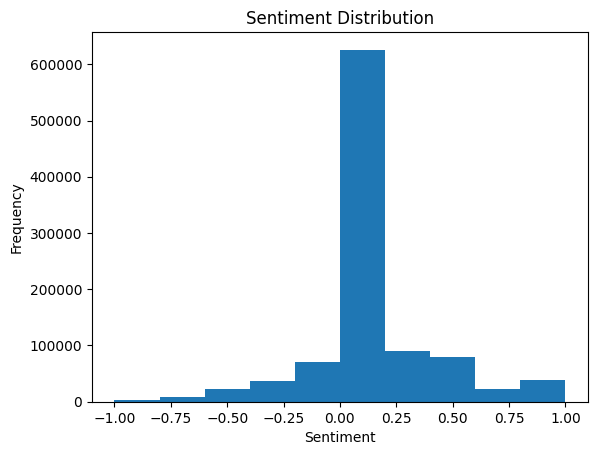

In [52]:
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.hist(df['sentiment'], bins=10)
plt.title('Sentiment Distribution')
plt.show()

Good sentiment:

In [53]:
len(df[df['sentiment']>=0])

857689

In [54]:
df['target'].value_counts()

0    938130
1     61870
Name: target, dtype: int64

In [55]:
low_sentiment = df[df['sentiment']<0]
low_sentiment[low_sentiment['target']==1].head()

,qid,question_text,target,processed_data,sentiment
6,a035227a3a8285020eee,Can Black People sustain Civilization?,1,"[Can, Black, People, sustain, Civilization, ?]",-0.166667
182,bd8e61da63e21a566e47,What makes humans so cruel? From Nazis to Isla...,1,"[What, makes, humans, so, cruel, ?, From, Nazi...",-0.450000
325,6c7d84aff80458b1af6b,Is morality dead in people (Tina Dani) using r...,1,"[Is, morality, dead, in, people, using, reserv...",-0.075926
381,c809aa55a91347bf47c7,Why are Chinese people so crazy in watermelon ...,1,"[Why, are, Chinese, people, so, crazy, in, wat...",-0.300000
448,c9c096a8e416e53f149f,Why is the holocaust story so bad?,1,"[Why, is, the, holocaust, story, so, bad, ?]",-0.700000


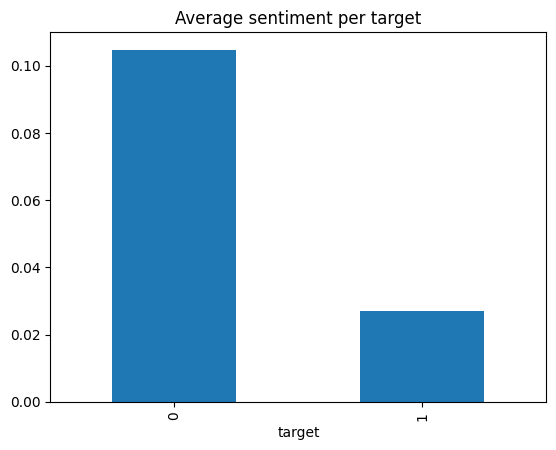

In [56]:
polarity_avg = df.groupby('target')['sentiment'].mean().plot(kind='bar')
plt.title('Average sentiment per target')
plt.show()

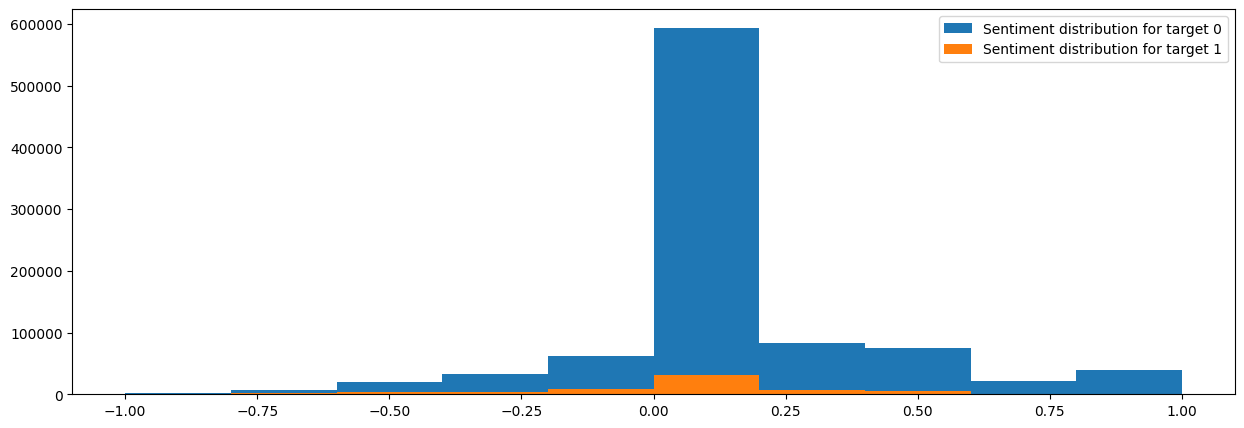

In [57]:
plt.figure(figsize=(15,5))
plt.hist(df[df['target']==0]['sentiment'], bins=10, label='Sentiment distribution for target 0')
plt.hist(df[df['target']==1]['sentiment'], bins=10, label='Sentiment distribution for target 1')
plt.legend()
plt.show()

In [58]:
# df['lemma_str'] = [' '.join(map(str,l)) for l in df['data_to_work_with']]
# df['word_count'] = df['data_to_work_with'].apply(lambda x: len(str(x).split()))
# df['review_len'] = df['lemma_str'].astype(str).apply(len)

In [59]:
df.head()

,qid,question_text,target,processed_data,sentiment
0,dda0b0efc8ba86e81ec4,What are interesting facts about Microsoft his...,0,"[What, are, interesting, facts, about, Microso...",0.5
1,dc708b74a108d0fc0ad9,What are those things which are not gonna happ...,0,"[What, are, those, things, which, are, not, go...",0.0
2,06a27ec5d82dacd8bfe0,"What should I know to avoid being ""upsold"" whe...",0,"[What, should, I, know, to, avoid, being, ``, ...",0.0
3,00cbb6b17e3ceb7c5358,How I add any account with payment bank?,0,"[How, I, add, any, account, with, payment, ban...",0.0
4,7c304888973a701585a0,Which Multi level marketing products are actua...,0,"[Which, Multi, level, marketing, products, are...",0.3


In [60]:
# import seaborn as sns
# corr_matrix = df[['target','sentiment', 'review_len', 'word_count']].corr()
# sns.heatmap(corr_matrix)

# Word frequency analysis

In [61]:
def common_words(data_column, top):
  all_words = []
  data_column.apply(lambda words: all_words.extend(words))
  most_common_words = FreqDist(all_words).most_common(top)
  x, y = zip(*most_common_words)
  plt.figure(figsize=(8,6))
  plt.bar(x,y)
  plt.xticks(rotation=60)
  plt.xlabel('Words')
  plt.ylabel('Frequency of Words')
  plt.show()

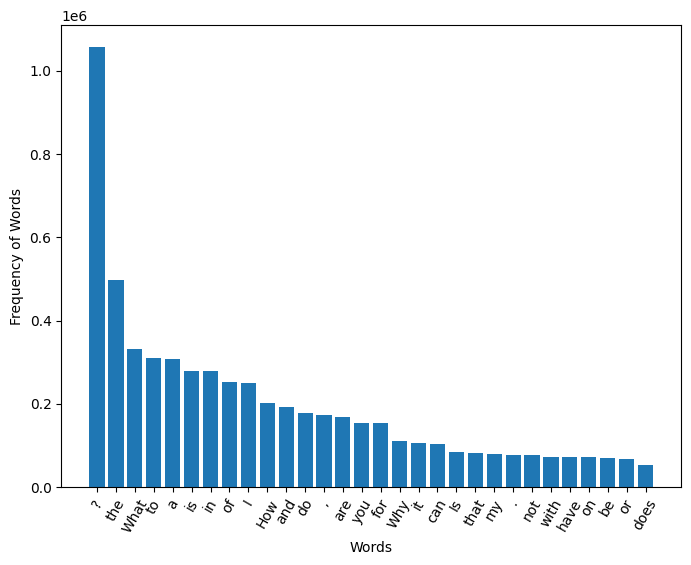

In [62]:
common_words(df['processed_data'],30)

In [63]:
target0 = df[df['target']==0]['processed_data']
target1 = df[df['target']==1]['processed_data']

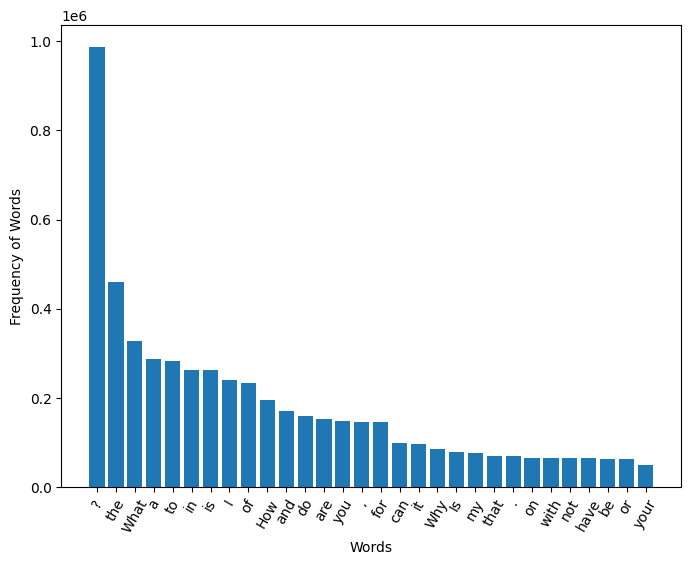

In [64]:
common_words(target0,30)

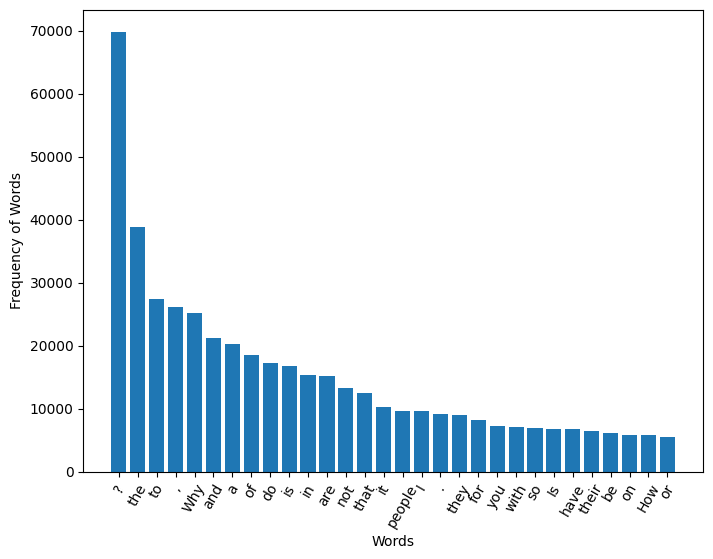

In [65]:
common_words(target1,30)

In [66]:
wordcloud = WordCloud(width = 648, height = 463, background_color ='white').generate(" ".join(df['question_text']))

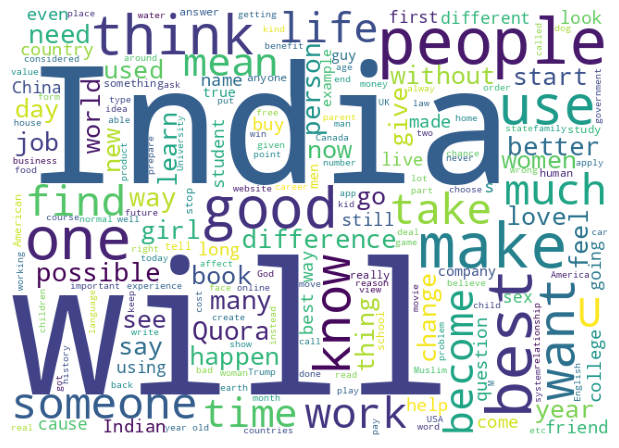

In [67]:
plt.figure(figsize = (6, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

# Training

## Count Vectorizer

In [ ]:
# vectorizer = CountVectorizer(min_df=2, lowercase=True, strip_accents='ascii', ngram_range = (1,3))
vectorizer = CountVectorizer(ngram_range = (1,3))
vectorizer.fit(full_df['question_text'])

In [ ]:
train_data = vectorizer.transform(df['question_text'])
test_data = vectorizer.transform(test_df['question_text'])

## TF-IDF

Term Frequency–Inverse Document Frequency: Gives advantage over using raw frequencies by reducing the bias due to tokens whose frequency is more.

In [ ]:
# vectorizer = TfidfVectorizer(min_df=2, max_features=100000)
# vectorizer.fit(full_df['processed_data'])

In [ ]:
# train_data = vectorizer.transform(df['question_text'])
# test_data = vectorizer.transform(test_df['question_text'])

## Word2Vec 


In [ ]:
# import gensim
# from sklearn.linear_model import LogisticRegression

In [ ]:
# model = gensim.models.Word2Vec(size=400, min_count=2, workers=4, sg=0)
# model.build_vocab(data)

In [ ]:
# mean_vectors = pd.DataFrame()
# for doc in data:
#     temp = pd.DataFrame()
#     for word in doc:
#           try:
#               word_vec = model.wv.get_vector(word)
#               temp = temp.append(pd.Series(word_vec), ignore_index = True)
#           except:
#               pass
#     mean_vector = temp.mean()
#     mean_vectors = mean_vectors.append(mean_vector, ignore_index = True)
# mean_vectors.shape

In [ ]:
# train_data = mean_vectors[0:df.shape[0], :]
# test_data = mean_vectors[df.shape[0]:, :]

## Models


### Gradient Boost

Took too long to train(over 4 hours)

In [ ]:
# model = GradientBoostingClassifier()

### AdaBoost

Took too long to train(over 4 hours)

In [ ]:
# model = AdaBoostClassifier()

### XGBoost

In [ ]:
# model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

### Other models tried

Took too long to train(over 3 hours)

In [ ]:
# model = LinearSVC()

SGDClassifier gave a very low score locally

In [ ]:
# model = SGDClassifier()

Both Decision Tree and Random Forest gave poor results on Kaggle (less than 0.20)

In [ ]:
# model = DecisionTreeClassifier(random_state=0)

In [ ]:
# model = RandomForestClassifier(max_depth=2, random_state=0)

Gaussian Naive Bayes gave decent results, but not better than Logistic Regression

In [ ]:
# model = GaussianNB()

### Multinomial Naive Bayes

Multinomial Naive Bayes also gave decent results, but not better than Logistic Regression

In [ ]:
# model = MultinomialNB(alpha=0.001)

### Multilayer Perceptron

Took a very long time to train, but gave decent results (At one point, our highest). But Logistic Regression, with some tuning, was able to perform better.

In [ ]:
# model = MLPClassifier(hidden_layer_sizes=5,activation='relu', learning_rate='invscaling',random_state=50, max_iter=35)

### Perceptron

Perceptron gave very poor results locally, taking minimal time to train.

In [ ]:
# model = Perceptron(random_state=46)

### Logistic Regression

Model used for submission with highest score.

In [ ]:
model = LogisticRegression(max_iter=3000,C=0.25, solver='lbfgs', penalty = 'l2',class_weight={0: 0.4, 1: 0.8},dual=False,intercept_scaling=1000)


Used gridsearchcv to find hyperparameters. Gave good results locally, but not on Kaggle. Did not use it for final submission.

In [ ]:
# grid = {"C":np.logspace(-3,3,7), "penalty":["l2"]}
# logreg = LogisticRegression()
# model = GridSearchCV(logreg,grid,cv=10)

### Training

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_data, df['target'], test_size=0.3, random_state=42)

In [ ]:
model.fit(x_train, y_train)

LogisticRegression(max_iter=1500)

In [ ]:
pred_prob = model.predict_proba(x_valid)[:, 1]

In [ ]:
y_pred = (pred_prob > 0.705).astype(np.int)

In [ ]:
f1_score(y_valid, y_pred)

0.6268265565438373

## Prediction on test data


In [ ]:
test_pred_prob = model.predict_proba(test_data)[:, 1]

In [ ]:
y_test_pred = (test_pred_prob > 0.2).astype(np.int)
test_df['target'] = y_test_pred

In [ ]:
test_df.drop('question_text', axis = 'columns', inplace=True)
test_df.to_csv("/content/drive/My Drive/Colab Notebooks/ML Project/submission.csv", index = False)